# SGG Evaluation Benchmarks

- Recall@50
- Recall@20
- Recall@100
- mR@50
- mR@20
- mR@100

In [2]:
#TODO: Parse input
import json

with open('relationships.json', 'r') as rel_file:
    relationships = json.load(rel_file)

with open('image_data.json', 'r') as img_file:
    image_data = json.load(img_file)

print("Successfully loaded both files!")


Successfully loaded both files!


In [4]:
relationships[0]

{'relationships': [{'predicate': 'ON',
   'object': {'name': 'street',
    'h': 262,
    'object_id': 5046,
    'synsets': ['street.n.01'],
    'w': 714,
    'y': 328,
    'x': 77},
   'relationship_id': 15927,
   'synsets': ['along.r.01'],
   'subject': {'name': 'shade',
    'h': 192,
    'object_id': 5045,
    'synsets': ['shade.n.01'],
    'w': 274,
    'y': 338,
    'x': 119}},
  {'predicate': 'wears',
   'object': {'name': 'sneakers',
    'h': 26,
    'object_id': 5048,
    'synsets': ['gym_shoe.n.01'],
    'w': 52,
    'y': 489,
    'x': 243},
   'relationship_id': 15928,
   'synsets': ['wear.v.01'],
   'subject': {'name': 'man',
    'h': 262,
    'object_id': 1058529,
    'synsets': ['man.n.01'],
    'w': 60,
    'y': 249,
    'x': 238}},
  {'predicate': 'has',
   'object': {'name': 'headlight',
    'h': 15,
    'object_id': 5050,
    'synsets': ['headlight.n.01'],
    'w': 23,
    'y': 366,
    'x': 514},
   'relationship_id': 15929,
   'synsets': ['have.v.01'],
   'subject': {

In [5]:
image_data[0]

{'width': 800,
 'url': 'https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg',
 'height': 600,
 'image_id': 1,
 'coco_id': None,
 'flickr_id': None}

In [20]:
def extract_filename(url):
    parts = url.split('/')
    if len(parts) > 2:
        return '_'.join(parts[-2:])
    return url

In [44]:
from collections import defaultdict

image_data_dict = {item['image_id']: item for item in image_data}

# Create a dictionary for relationships grouped by image_id
ground_truth_dict = defaultdict(list)
for rel in relationships:
    image_id = rel.get('image_id')
    if image_id in image_data_dict:
        img_data = image_data_dict[image_id]
        url = img_data.get('url', '')
        filename = extract_filename(url)
        ground_truth_dict[filename].append({
            **rel,
            **img_data,
            'filename': filename
        })

# Save the result to ground_truth.json
# ground_truth = [item for sublist in ground_truth_dict.values() for item in sublist]
with open('ground_truth.json', 'w') as output_file:
    json.dump(ground_truth_dict, output_file, indent=4)

print("ground_truth.json has been created successfully!")

ground_truth.json has been created successfully!


In [46]:
with open('ground_truth.json', 'r') as rel_file:
    ground_truth = json.load(rel_file)

In [60]:
print(f'{next(iter(ground_truth))}:')
ground_truth[next(iter(ground_truth))]

VG_100K_2_1.jpg:


[{'relationships': [{'predicate': 'ON',
    'object': {'name': 'street',
     'h': 262,
     'object_id': 5046,
     'synsets': ['street.n.01'],
     'w': 714,
     'y': 328,
     'x': 77},
    'relationship_id': 15927,
    'synsets': ['along.r.01'],
    'subject': {'name': 'shade',
     'h': 192,
     'object_id': 5045,
     'synsets': ['shade.n.01'],
     'w': 274,
     'y': 338,
     'x': 119}},
   {'predicate': 'wears',
    'object': {'name': 'sneakers',
     'h': 26,
     'object_id': 5048,
     'synsets': ['gym_shoe.n.01'],
     'w': 52,
     'y': 489,
     'x': 243},
    'relationship_id': 15928,
    'synsets': ['wear.v.01'],
    'subject': {'name': 'man',
     'h': 262,
     'object_id': 1058529,
     'synsets': ['man.n.01'],
     'w': 60,
     'y': 249,
     'x': 238}},
   {'predicate': 'has',
    'object': {'name': 'headlight',
     'h': 15,
     'object_id': 5050,
     'synsets': ['headlight.n.01'],
     'w': 23,
     'y': 366,
     'x': 514},
    'relationship_id': 15929,
 

### Recall@K and Precision@K

In [ ]:
def recall_at_k(predictions, ground_truth_dict, K):
    """
    Calculate Recall@K for scene graph evaluation.
    
    Args:
        predictions (dict): Predictions for images, where keys are filenames and values are lists of triplets.
        ground_truth_dict (dict): Ground truth relationships indexed by filename.
        K (int): The top-K predictions to consider.
        
    Returns:
        float: The Recall@K value. When more than one image is passed in, it returns the mean Recall@K value.
    """
    total_correct = 0
    total_preds = 0

    for filename, pred_list in predictions.items():
        if filename not in ground_truth_dict:
            continue
        
        gt_relationships = ground_truth_dict[filename][0]['relationships']
        gt_triplets = {(rel['subject']['name'], rel['predicate'], rel['object']['name']) for rel in gt_relationships}
        
        sorted_preds = sorted(pred_list, key=lambda x: x['confidence'], reverse=True)[:K]
        pred_triplets = {(pred['subject']['name'], pred['predicate'], pred['object']['name']) for pred in sorted_preds}

        total_correct += len(gt_triplets & pred_triplets)
        total_preds += len(gt_triplets)

    if total_preds == 0:
        return 0.0

    return total_correct / total_preds


def precision_at_k(predictions, ground_truth_dict, K):
    """
    Calculate Precision@K for scene graph evaluation.
    
    Args:
        predictions (dict): Predictions for images, where keys are filenames and values are lists of triplets.
        ground_truth_dict (dict): Ground truth relationships indexed by filename.
        K (int): The top-K predictions to consider.
        
    Returns:
        float: The Precision@K value.  When more than one image is passed in, it returns the mean Precision@K value.
    """
    total_correct = 0
    total_preds = 0

    for filename, pred_list in predictions.items():
        if filename not in ground_truth_dict:
            continue
        
        gt_relationships = ground_truth_dict[filename][0]['relationships']
        gt_triplets = {(rel['subject']['name'], rel['predicate'], rel['object']['name']) for rel in gt_relationships}

        sorted_preds = sorted(pred_list, key=lambda x: x['confidence'], reverse=True)[:K]
        pred_triplets = {(pred['subject']['name'], pred['predicate'], pred['object']['name']) for pred in sorted_preds}

        total_correct += len(gt_triplets & pred_triplets)
        total_preds += len(pred_triplets)

    if total_preds == 0:
        return 0.0

    return total_correct / total_preds


In [70]:
#example predictions
predictions = {
   "VG_100K_2_1.jpg": [ 
        {
            "predicate": "following",
            "object": {
                "name": "taxi",
                "x": 248.99999999999997,
                "y": 401.5,
                "w": 120.00000000000003,
                "h": 67.0
            },
            "subject": {
                "name": "car",
                "x": 455.5,
                "y": 422.0,
                "w": 227.0,
                "h": 94.0
            },
            "confidence": 0.7744973301887512
        },
        {
            'predicate': 'ON',
            'object': {
                'name': 'street',
                'h': 262,
                'w': 714,
                'y': 328,
                'x': 77},
            'subject': {
                'name': 'shade',
                'h': 192,
                'w': 274,
                'y': 338,
                'x': 119},
            "confidence": 0.7744973301887512
        }
    ]
}

In [80]:
recall = recall_at_k(predictions, ground_truth, 5)
precision = precision_at_k(predictions, ground_truth, 5)
recall, precision

(0.02857142857142857, 0.5)

In [81]:
def f1_score(recall, precision):
    if recall + precision == 0:
        return 0.0  # Avoid division by zero.

    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

f1 = f1_score(recall, precision)
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.05


In [82]:
import matplotlib.pyplot as plt

def plot_recall_precision(k_values, recall_scores, precision_scores, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, recall_scores, label="Recall@K", marker='o')
    plt.plot(k_values, precision_scores, label="Precision@K", marker='s')
    plt.plot(k_values, f1_scores, label="F1@K", marker='x')

    plt.title("Recall@K, Precision@K and F1 Scores")
    plt.xlabel("K")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.show()


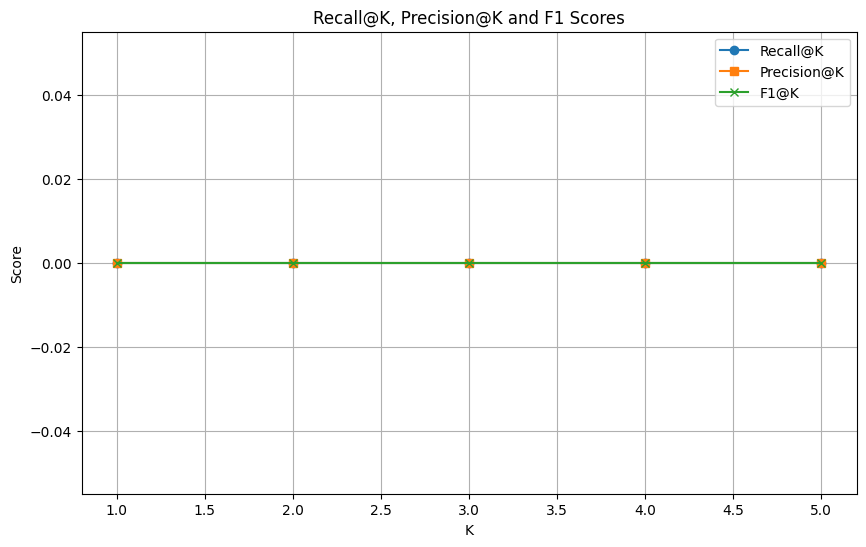

In [83]:


k_values = list(range(1, 6))
recall_scores = []
precision_scores = []
f1_scores = []

for K in k_values:
    recall = recall_at_k(predictions, ground_truths, K)
    precision = precision_at_k(predictions, ground_truths, K)
    f1 = f1_score(recall, precision)
    
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)
    
plot_recall_precision(k_values, recall_scores, precision_scores, f1_scores)

In [19]:
def evaluate(predictions, ground_truths, K):
    recall = recall_at_k(predictions, ground_truths, K)
    precision = precision_at_k(predictions, ground_truths, K)
    # f1 = f1_score(recall, precision)
    return recall, precision

recall, precision

(1.0, 0.6)